In [884]:
import nbsetup
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare, chi2_contingency
from helpers.ergodic import ErgodicEnsemble

# Setting up the standard code

In [890]:
MAX = 20

CASES = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o),
    "power 4-4.5": lambda i, o: np.random.power(4 if i == 1 else 4.5,o)*MAX,
    "power 2-3": lambda i, o: np.random.power(2 if i == 1 else 3,o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(2 if i == 1 else 2.5,o)*MAX,
    "power 2-2.1": lambda i, o: np.random.power(2 if i == 1 else 2.1,o)*MAX,
    "normal 5-5.2": lambda i, o: np.random.normal(5 if i == 1 else 5.2, 0.5, o),
    "normal 5-5.1": lambda i, o: np.random.normal(5 if i == 1 else 5.1, 0.5, o),
}


def chi_p(ee):
    #chi2, p = chisquare(ee.histograms[0], ee.histograms[1])
    try:
        chi2, p, dof, expected = chi2_contingency(ee.histograms)
    except ValueError: # if a bin is zero
        return None
    else:
        return p


def get_results(gen, name, b, o, ensembles, trials):
    filename = "../datasets/chisquare/%s.json" % ("-".join([str(n) for n in (name, b, o, ensembles, trials)]))
    
    try:
        nbsetup.cp("loading", name, b, o)
        with open(filename, 'r') as myfile:
            data = json.loads(myfile.read())
        
    except FileNotFoundError:
        nbsetup.cp("generating", name, b, o)
        data = create_results(gen, name, b, o, ensembles, trials)
    
        # now save
        with open(filename, "w") as outfile:
            json.dump(data, outfile)
    
    return data
    
def create_results(gen, name, b, o, ensembles, trials):
    results = []
    for t in range(trials):        
        # generate data
        observations = []
        for e in range(ensembles):
            observations.append(gen(e, o))
        observations = np.array(observations)
        # create EE
        bins = np.linspace(int(np.floor(observations.min())), int(np.ceil(observations.max())), max(b+1,3))
        ee = ErgodicEnsemble(observations=observations, bins=bins)
        
        results.append({
            'bin': b,
            'obs': o,
            'dist': name,
            'ensembles': ensembles,
            'complexity': ee.complexity,
            'p': chi_p(ee),
        })
    return results
    

def gen_data(cases, bin_range, obs_range, ensembles=2, trials=1000):
    data = []
    for name, gen in cases.items():
        for b in bin_range:
            for o in obs_range:
                data += get_results(gen, name, b, o, ensembles, trials)
    nbsetup.cp("finished gen_data")
    return data

In [848]:
ID_VARS = ['obs', 'bin', 'dist', 'ensembles']

def tf_transform(dataframe, rules):
    new_df = dataframe.copy()
    
    # do the bool analysis
    analysis = {}
    
    nbsetup.cp("Analysing", len(new_df.index))
    for _, row in new_df.iterrows():
        for rule_name, rule in rules.items():
            val = rule(row)
            # auto deal with if it's the first one in the list
            try:
                analysis[rule_name].append(val)
            except KeyError:
                analysis[rule_name] = [val]
    
    # store the data as new dataframe
    for k,v in analysis.items():
        new_df[k] = v
    
    # clear off unneeded data from the dataframe
    for k in ['complexity','p']:
        try:
            new_df = new_df.drop(columns=[k])
        except KeyError:
            pass
    return new_df

In [875]:
def relplot(dataframe, absolute=False):
    nbsetup.cp("Plotting")
    # print relplot of the absolute values
    filt = dataframe
    melt = filt.melt(id_vars=ID_VARS)
    g = sns.relplot(data=melt, kind='line', col='bin', row='dist', x='obs', y='value', hue='variable', legend='full')
    
    # if comparing absolute values
    if absolute:
        g.map(plt.axhline, y=0.05, color=".7", dashes=(2, 1), zorder=0)
        g.map(plt.axhline, y=0.01, color=".7", dashes=(2, 1), zorder=0)
        g.set(xscale="log", yscale="log", ylim=(0.0001,1.0))
        g.set_axis_labels("Observations", "p-value")
        g.tight_layout(w_pad=0)
    else:
        #g.set(xscale="log")
        g.set(ylim=(-0.01,1))
    nbsetup.cp("")

# Investigations

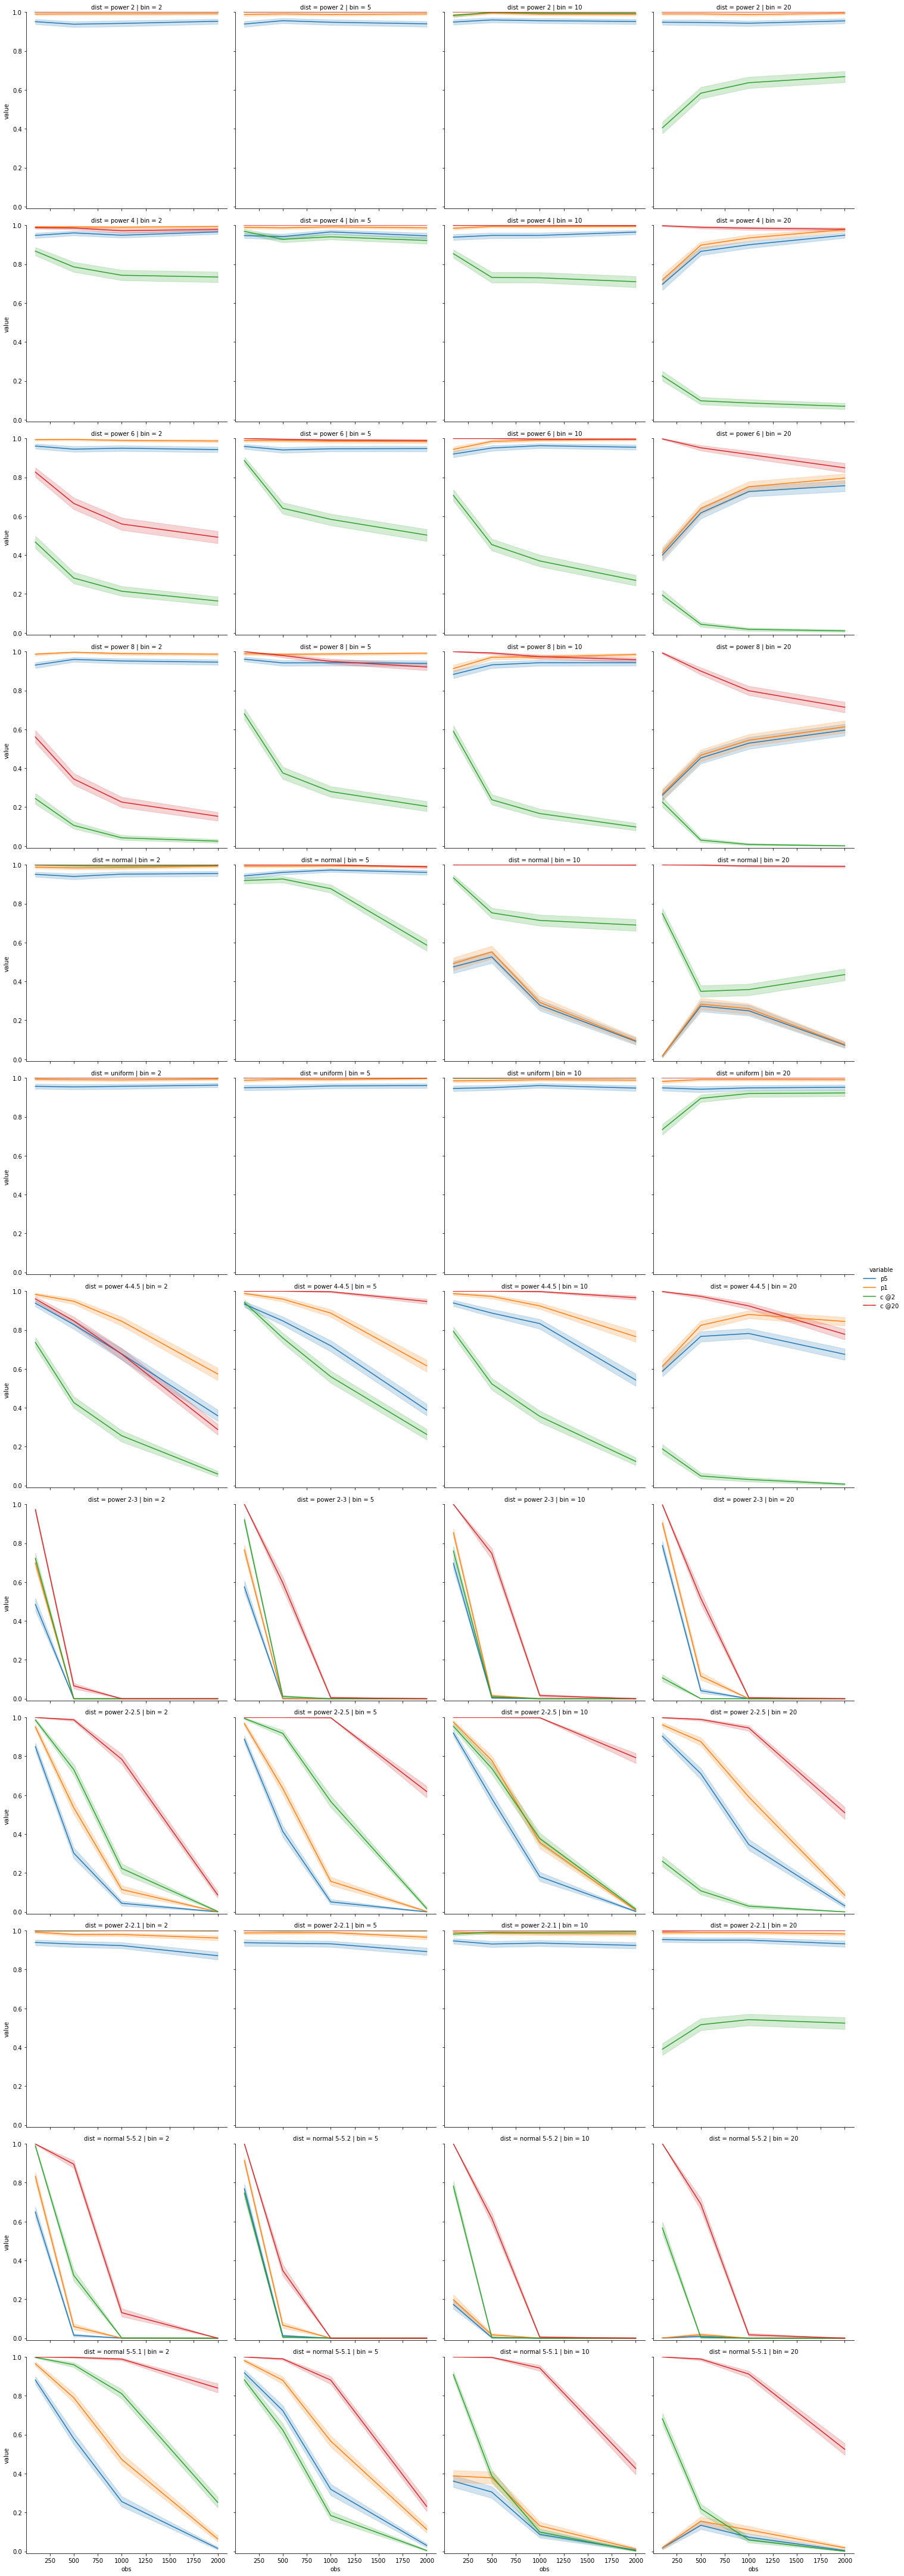

In [882]:
mini_names = ['power 2', 'power 6', 'power 8', 'normal', 'power 2-3', 'normal 5-5.2']
mini_cases = dict([(name, CASES[name]) for name in mini_names])

small = pd.DataFrame(gen_data(CASES, [2,5,10,20], [100,500,1000,2000], ensembles=20))

rules = {
    'p5': lambda r: 1.0 if r.p > 0.05 else 0.0,
    'p1': lambda r: 1.0 if r.p > 0.01 else 0.0,
    
    # current testing mess
    'c @2': lambda r: 1.0 if r.complexity < (2+(r.bin/15))/r.obs else 0.0,
    'c @20':lambda r:  1.0 if r.complexity < (3+(r.bin/15))/r.obs else 0.0,
}

relplot(tf_transform(small, rules))

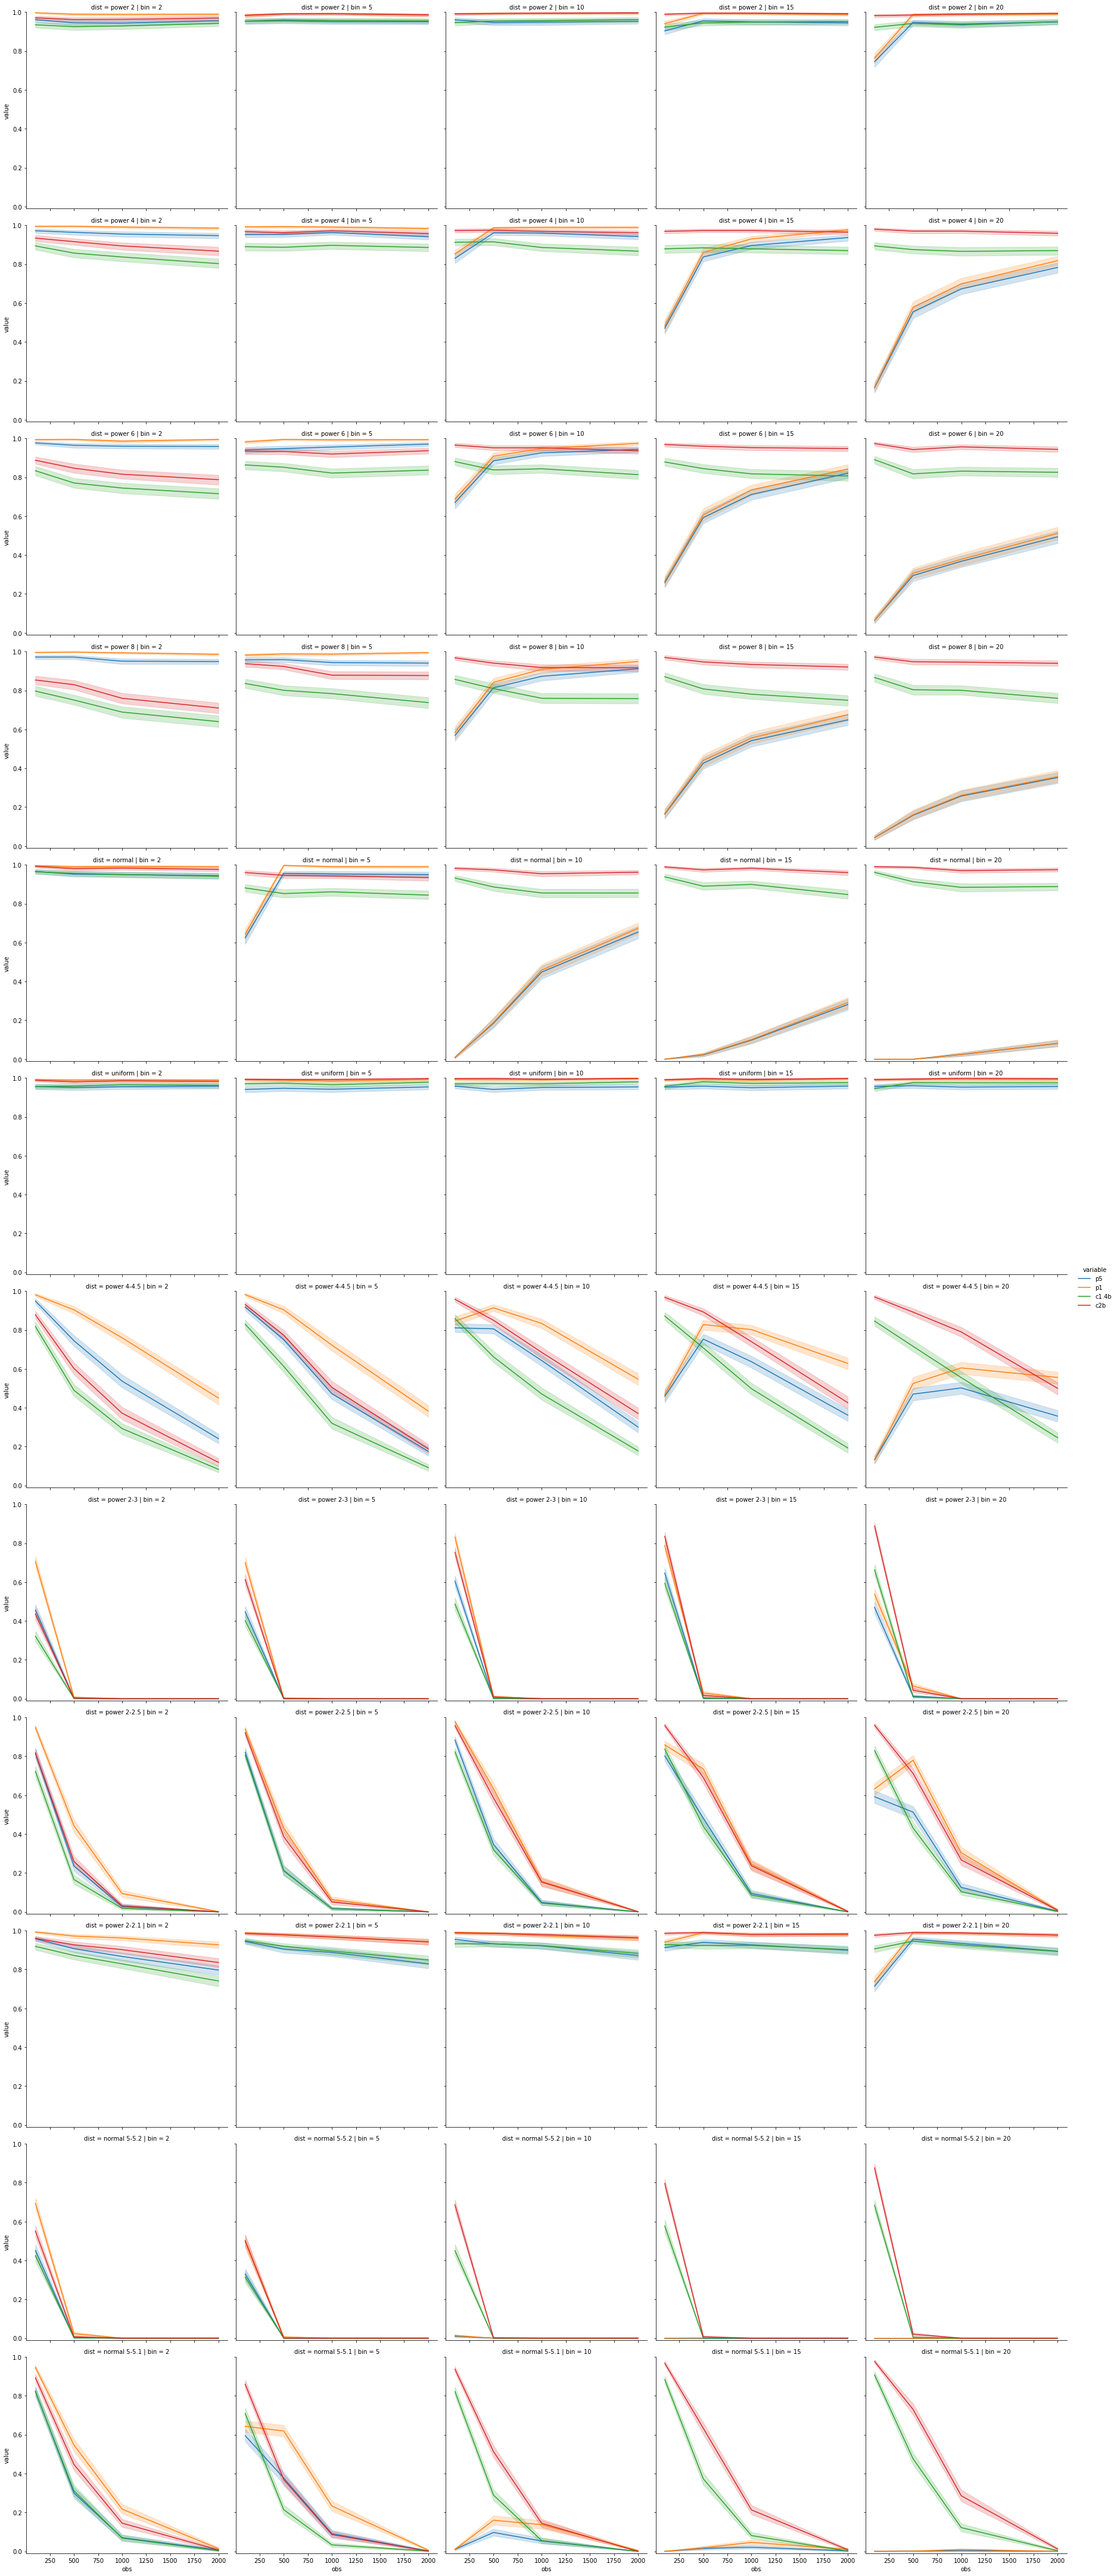

In [891]:
double = pd.DataFrame(gen_data(CASES, [2,5,10,15,20], [100,500,1000,2000], ensembles=2))

rules = {
    'p5': lambda r: 1.0 if r.p > 0.05 else 0.0,
    'p1': lambda r: 1.0 if r.p > 0.01 else 0.0,
    
    # introducing obs to smooth
    #'c5': lambda r: 1.0 if r.complexity < (2**0.5/r.obs) else 0.0,
    #'c1': lambda r: 1.0 if r.complexity < 1/r.obs else 0.0,
    
    # introducing bins to smooth
    'c1.4b': lambda r: 1.0 if r.complexity < (1.4+(r.bin/15))/r.obs else 0.0,
    'c2b':lambda r:  1.0 if r.complexity < (2+(r.bin/15))/r.obs else 0.0,
}

relplot(tf_transform(double, rules))

In [ ]:
multiple = pd.DataFrame(gen_data(CASES, [2,5,10,15,20], [50, 100,500,1000,2000], ensembles=20))
#relplot(tf_transform(multiple, rules))

generating power 4 2 2000


# Calculating adjustment for bin

There appears to be a relationship between the number of bins (which is akin to degree's of freedom with chisquare). Investigating what that relationship might be.

- After plotting, it appears to be linear.
- After then plotting for for each different distribution, the relationship is consistent.
- It's so consistent even what looks to be minor variance bumps are consistent. However, we'll ignore these for now for the sake of simplicity.

### Bins over distributions

In [656]:
bin_500 = pd.DataFrame(gen_data(CASES, range(2,16,2), [500], ensembles=20))

normal 5-5.1 14 500


In [657]:
bin_1000 = pd.DataFrame(gen_data(CASES, range(2,16,2), [1000], ensembles=20))

normal 5-5.1 14 1000


In [681]:
def regressions(df):
    regressions = {}
    for k in df['dist'].unique():
        means = df[df['dist']==k].loc[:,['bin','dist','complexity']].groupby('bin').mean()
        x = means.reset_index()['bin']
        y = means['complexity']
        model = np.polyfit(x, y, 1)
        regressions[k] = model[0]
    return regressions

def plot_regressions(df):
    melt = df.melt(id_vars=['dist','bin','obs'])
    sns.lineplot(data=melt, x='bin', y='value', hue='variable')

normal 5-5.1 14 2000


<AxesSubplot:xlabel='index', ylabel='value'>

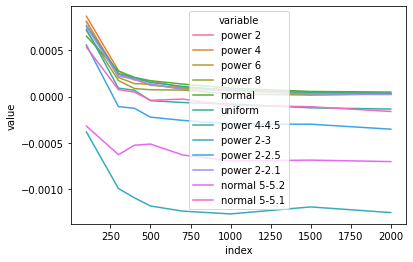

In [694]:
for o in [300, 400, 1500, 2000]:
    bin_results[o] = regressions(pd.DataFrame(gen_data(CASES, range(2,16,2), [o], ensembles=10)))

df_regs = pd.DataFrame(bin_results).T
df_regs.reset_index(inplace=True)
sns.lineplot(data=df_regs.melt(id_vars='index'), x='index', y='value', hue='variable')

In [695]:
df_regs

,index,power 2,power 4,power 6,power 8,normal,uniform,power 4-4.5,power 2-3,power 2-2.5,power 2-2.1,normal 5-5.2,normal 5-5.1
0,100,0.000809,0.000865,0.000808,0.000710,0.000651,0.000764,0.000724,-0.000381,0.000555,0.000750,-0.000317,0.000533
1,500,0.000169,0.000122,0.000133,0.000074,0.000171,0.000152,-0.000044,-0.001178,-0.000221,0.000132,-0.000511,-0.000040
2,700,0.000098,0.000095,0.000084,0.000070,0.000135,0.000110,-0.000064,-0.001233,-0.000256,0.000079,-0.000628,-0.000027
3,1000,0.000072,0.000068,0.000078,0.000027,0.000090,0.000066,-0.000080,-0.001263,-0.000295,0.000063,-0.000693,-0.000094
4,300,0.000242,0.000280,0.000205,0.000173,0.000274,0.000249,0.000091,-0.000990,-0.000108,0.000221,-0.000625,0.000075
5,400,0.000179,0.000185,0.000139,0.000086,0.000207,0.000204,0.000068,-0.001090,-0.000126,0.000187,-0.000523,0.000049
6,1500,0.000049,0.000040,0.000021,0.000017,0.000056,0.000043,-0.000121,-0.001188,-0.000297,0.000029,-0.000684,-0.000109
7,2000,0.000036,0.000028,0.000025,0.000030,0.000049,0.000037,-0.000134,-0.001249,-0.000351,0.000023,-0.000700,-0.000160


normal 5-5.1 51 1000


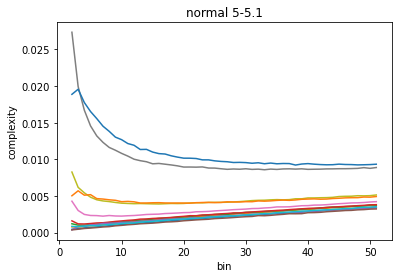

In [652]:
regressions = {}
for dist in CASES.keys():
    regressions[dist] = calc_bin_regression(dist, obs=1000)

In [ ]:
regressions

### Bins over observations

normal 20 2000


{100: array([ 0.00214586, -0.0003125 ]),
 200: array([0.00049718, 0.00158173]),
 500: array([0.0001765 , 0.00082249]),
 800: array([0.00011257, 0.0005023 ]),
 1000: array([7.77609844e-05, 4.95786217e-04]),
 1500: array([5.19537161e-05, 3.41492827e-04]),
 2000: array([4.06653683e-05, 2.46318368e-04])}

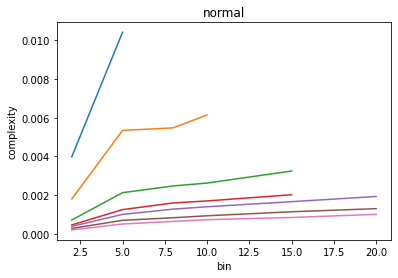

In [651]:
obs_regressions = {}
checkers = [
    (100, [2,5]),
    (200, [2,5,8,10]),
    (500, [2,5,8,10,15]),
    (800, [2,5,8,10,15]),
    (1000, [2,5,8,10,15,20]),
    (1500, [2,5,8,10,15,20]),
    (2000, [2,5,8,10,15,20]),
]
for obs, bins in checkers:
    obs_regressions[obs] = calc_bin_regression('normal', obs, bins)
obs_regressions

### Adjusting for bin

In [567]:
bin_m = regressions['power 2'][0]

In [ ]:
normal_check = pd.DataFrame(gen_data({'normal':CASES['normal']}, [3,5,7,10], [100, 500, 1000, 2000], trials=100, ensembles=20))

,bin,obs,dist,complexity,adjust
0,3,100,normal,0.010191,0.009896
1,3,100,normal,0.011848,0.011553
2,3,100,normal,0.002064,0.001768
3,3,100,normal,0.010909,0.010614
4,3,100,normal,0.007143,0.006848
...,...,...,...,...,...
1595,10,2000,normal,0.001083,0.000099
1596,10,2000,normal,0.001163,0.000180
1597,10,2000,normal,0.000472,-0.000512
1598,10,2000,normal,0.000862,-0.000122


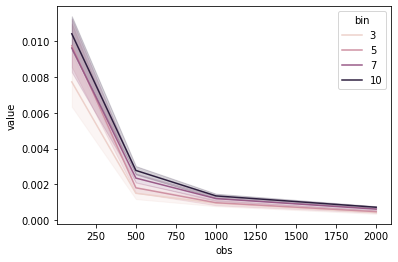

In [647]:
def check_regression_calc(data):
    data = data.assign(adjust = lambda r: r.complexity-bin_m*r.bin)
    data = data.drop(columns=['c','p'])
    melt = data.loc[:,['obs','bin','dist','complexity']].melt(id_vars=['obs', 'bin', 'dist'])
    #g = sns.relplot(data=melt, kind='line', col='bin', row='dist', x='obs', y='value', hue='variable', legend='full')
    g = sns.lineplot(data=melt, x='obs', y='value', hue='bin', legend='full')
    return data
    
check_regression_calc(normal_check)

# Observation regressions

In [ ]:
def calc_bin_regression(dist, obs=500):
    data = pd.DataFrame(gen_data({dist:CASES[dist]}, range(2,52,1), [obs], trials=1000, ensembles=20))
    means = data.loc[:,['bin','complexity']].groupby('bin').mean()
    x = means.reset_index()['bin']
    y = means['complexity']
    model = np.polyfit(px, py, 1)
    g = sns.lineplot(data=bin_madness, x="bin", y="complexity")
    g.set_title(dist)
    return model